In [129]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-data/data.csv


In [130]:
df= pd.read_csv('../input/ecommerce-data/data.csv')

#copy data into new df for analysis
data=df.copy()

data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [131]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### 1. Cohort Analysis:

We first divide the entire data into different cohorts to understand high-level trends. We use time cohort for our analysis here:

In [132]:
#generate invoice month for each line purchase equal to the first day of the month when the purchase was made
data['InvoiceMonth'] = pd.to_datetime(data['InvoiceDate']).to_numpy().astype('datetime64[M]')

#first invoice month for every customer
data['CohortMonth'] = data.groupby('CustomerID')['InvoiceMonth'].transform('min')

#drop null values
data.dropna(inplace=True)

data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01


In [133]:
#drop NaN values
data.dropna()

#compute year and month from Invoice Date
invoice_year= data['InvoiceMonth'].dt.year.astype('int')
invoice_mon= data['InvoiceMonth'].dt.month.astype('int')

#compute year and month from Cohort Date
cohort_year= data['CohortMonth'].dt.year.astype('int')
cohort_mon= data['CohortMonth'].dt.month.astype('int')

#find the differences
diff_year = invoice_year - cohort_year
diff_mon = invoice_mon - cohort_mon

#calculate the cohort index for each invoice
data['CohortIndex'] = diff_year * 12 + diff_mon + 1
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1


In [134]:
#group by cohort month and index and find number of unique customers for each grouping
grouped = data.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].apply(pd.Series.nunique)\
                                                                    .reset_index()
#pivot the data with cohort month as rows and Cohort Index as columns
grouped = grouped.pivot(index='CohortMonth', columns='CohortIndex',  values='CustomerID')
grouped

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02-01,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03-01,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04-01,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05-01,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In the table above, the first column values represents the size of every individual cohort, and the subsequent columns represent the number of active customers for that cohort in the subsequent months.

In [135]:
#divide each column by value of the first(cohort size) to find retention rate
size = grouped.iloc[:,0]
retention_table = grouped.divide(size, axis=0)

#compute the percentage
retention_table.round(3) * 100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,38.2,33.4,38.7,36.0,39.7,38.0,35.4,35.4,39.5,37.3,50.0,27.4
2011-01-01,100.0,24.0,28.3,24.2,32.8,29.9,26.1,25.7,31.1,34.7,36.8,15.0,NaN
2011-02-01,100.0,24.7,19.2,27.9,26.8,24.7,25.5,28.2,25.8,31.3,9.2,NaN,NaN
2011-03-01,100.0,19.1,25.5,21.8,23.2,17.7,26.4,23.9,28.9,8.9,NaN,NaN,NaN
2011-04-01,100.0,22.7,22.1,21.1,20.7,23.7,23.1,26.1,8.4,NaN,NaN,NaN,NaN
2011-05-01,100.0,23.7,17.2,17.2,21.5,24.4,26.5,10.4,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,20.9,18.7,27.2,24.7,33.6,10.2,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,20.9,20.4,23.0,27.2,11.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,25.1,25.1,25.1,13.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's now visualize the retention rates on a heatmap:

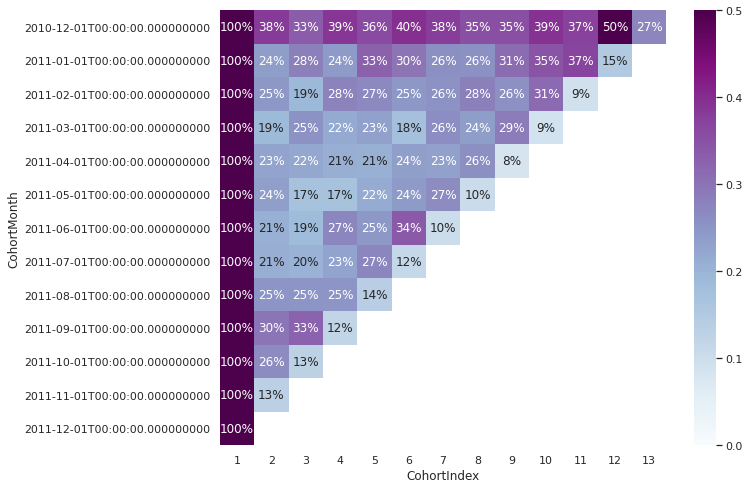

In [136]:
plt.figure(figsize=(10, 8))

sns.heatmap(data = retention_table,
            annot = True,        
            fmt = '.0%',         
            vmin = 0.0,          
            vmax = 0.5,           
            cmap = 'BuPu')
plt.show()

 ### 2. RFM Segmentation:
 RFM segmentation technique takes into account the past purchase behaviour and patterns of the customers to divide them into segments. Here 'R', 'F', 'M' denote Recency, Frequency and Monetary analysis respectively.
 
* Recency: Number of days since a customer's last purchase
* Frequency: Number of purchases by the customer
* Monetary: Total amount of money spent by the customer on his purchases
  
We will be sorting the customers into quartiles based on these three metrics, and calculating their RFM score. With the help of this score, we can effectively sort the customers into segments which can be used for targeting particular segments for campaigns, promotions or other personalized experiences.
 
For our ease of analysis, we'll be moving forward with the assumption that the date of our RFM analysis is  just the day after the most recent invoice date in the dataset.

In [137]:
#copy data into a new dataframe for analysis
data_all= df.copy()

#calculating total the total amount for each line item (unit price * Quantity)
data_all['amount']= data_all['Quantity']* data_all['UnitPrice']
data_all.head()

#convert column to datetime
data_all['InvoiceDate']=pd.to_datetime(data_all['InvoiceDate'])

#setting date of analysis= 1 day after the most recent invoice
analysis_date = pd.to_datetime(data_all['InvoiceDate'].max())+ dt.timedelta(days=1)
data_all.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [138]:
#calculate the recency, frequency and Monetary values for each customer
grouped = data_all.groupby(['CustomerID'])\
                .agg({'InvoiceDate': lambda x: (analysis_date - x.max()).days,
                      'InvoiceNo': 'count',
                      'amount': 'sum'})\

#rename each column to denote the R,F,M Values
grouped.rename(columns = {'InvoiceDate': 'R_val',
                                   'InvoiceNo': 'F_val',
                                   'amount': 'M_val'}, inplace=True)
grouped.reset_index().head()

,CustomerID,R_val,F_val,M_val
0,12346.0,326,2,0.00
1,12347.0,2,182,4310.00
2,12348.0,75,31,1797.24
3,12349.0,19,73,1757.55
4,12350.0,310,17,334.40


In [139]:
#divide recency metric into 4 quartiles
r_quartiles = pd.qcut(grouped['R_val'], 4, labels = range(4, 0, -1))
grouped = grouped.assign(R_quartile = r_quartiles.values.astype('int'))

#divide frequency metric into 4 quartiles
f_quartiles = pd.qcut(grouped['F_val'], 4, labels = range(1, 5, 1))
grouped = grouped.assign(F_quartile = f_quartiles.values.astype('int'))

#divide monetary metric into 4 quartiles
m_quartiles = pd.qcut(grouped['M_val'], 4, labels = range(1, 5, 1))
grouped = grouped.assign(M_quartile = m_quartiles.values.astype('int'))

grouped.head()
grouped.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4372 entries, 12346.0 to 18287.0
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   R_val       4372 non-null   int64  
 1   F_val       4372 non-null   int64  
 2   M_val       4372 non-null   float64
 3   R_quartile  4372 non-null   int64  
 4   F_quartile  4372 non-null   int64  
 5   M_quartile  4372 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 239.1 KB


Now that we have the R,F,M quartiles, we'll move on to calculating the RFM scores as a sum total of all the three quartiles and assigning RFM segments.

In [140]:
#get RFM segment by concatenation of R,F,M values
grouped['RFM_Seg']=grouped['R_quartile'].astype('str') + grouped['F_quartile'].astype('str') + grouped['M_quartile'].astype('str')

#calculate RFM by summing R,F,M values
grouped['RFM_Score']= grouped[['R_quartile','F_quartile','M_quartile']].sum(axis=1)
grouped.head()

,R_val,F_val,M_val,R_quartile,F_quartile,M_quartile,RFM_Seg,RFM_Score
CustomerID,,,,,,,,
12346.0,326,2,0.00,1,1,1,111,3
12347.0,2,182,4310.00,4,4,4,444,12
12348.0,75,31,1797.24,2,2,4,224,8
12349.0,19,73,1757.55,3,3,4,334,10
12350.0,310,17,334.40,1,1,2,112,4


Visualizing the total count of each RFM Segment:

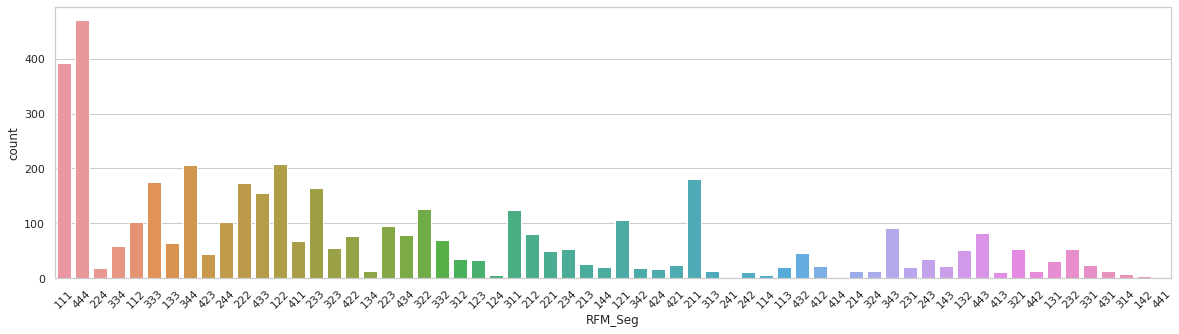

In [141]:
#set sns theme
sns.set_theme(style="whitegrid")

#set plot size
fig, ax = plt.subplots(figsize=(20, 5))

#plot count of each RFM segment
sns.countplot(x="RFM_Seg", data=grouped)
plt.xticks(rotation=45)

plt.show()

We can clearly see that segment '111'(Worst customers) and segment '444'(best customers) have the highest count.

Now as per the business requirements, we can analyse each segment. 

First, we group the customers into different tiers based on their total RFM Score. In decreasing order of their RFM scores, they are as follows:
1. Platinum
2. Gold
3. Advanced
4. Basic

In [142]:
def get_tier(a):
    if a >9:
        return 'Platinum'
    elif (a>6) & (a<=9):
        return 'Gold'
    elif (a>3) & (a<=6):
        return 'Advanced'
    elif (a>0) & (a<=3):
        return 'Basic' 

#assign a tier to each customer based on the get_tier function logic
grouped['Tier']=grouped['RFM_Score'].apply(get_tier)
grouped.head()

,R_val,F_val,M_val,R_quartile,F_quartile,M_quartile,RFM_Seg,RFM_Score,Tier
CustomerID,,,,,,,,,
12346.0,326,2,0.00,1,1,1,111,3,Basic
12347.0,2,182,4310.00,4,4,4,444,12,Platinum
12348.0,75,31,1797.24,2,2,4,224,8,Gold
12349.0,19,73,1757.55,3,3,4,334,10,Platinum
12350.0,310,17,334.40,1,1,2,112,4,Advanced


Next, let us compute the mean of the R-F-M values of each tier and also their counts.

In [143]:
df_reset= grouped.reset_index()
tier_analysis=df_reset.groupby(['Tier'])\
        .agg({'R_val': 'mean',
                      'F_val': 'mean',
                      'M_val': 'mean'}).round(2)
print(tier_analysis,'\n')
print(grouped['Tier'].value_counts())

           R_val   F_val    M_val
Tier                             
Advanced  139.15   21.60   362.08
Basic     264.77    7.83   109.08
Gold       62.42   57.99  1012.67
Platinum   19.13  232.37  5017.44 

Advanced    1376
Gold        1325
Platinum    1279
Basic        392
Name: Tier, dtype: int64


We can see that the tiers have very distinctive properties, and they can be further analysed as per business needs.

A few takeaways:

1. Tiers with higher Recency values: These are the inactive customers. Surveys should be undertaken to understand their experience and pain-points with the store/app and appropriate measures should be taken in an effort to re-engage them

2. Tiers with lower Frequeny Values: These customers should be targeted with additional offers and campaigns from time to time to increase their frequency of purchase

3. Tiers with lower Monetary Values: For these customers, marketing and pricing strategies need to be formulated to increase their basket value. This can be achieved by offering discounts on a minimum cart price or bulk purchase discounts

Now, let's do an analysis of the tiers country-wise. This will help us understand which are the best and worst performing regions.

We will find out the top 5 countries with the largest percentage of the customers in the Basic Tier and the top 5 countries with the largest percentage of customers in the Platinum Tier.

In [144]:
#find total customers in each country
country_count=data_all.groupby(['Country']).size().to_frame('Total_Customers_in_country').reset_index()
country_count.head()

#merge with original df to add the 'Country' column
df_with_country = df_reset.merge(data_all[['CustomerID','Country']], how='inner', on='CustomerID')
result= df_with_country.groupby(['Tier','Country']).size().to_frame('Customer_count').reset_index()
country_data= result.merge(country_count, how='inner', on='Country')

#get filtered dataset for Basic Tier
basic_tier= country_data[country_data['Tier'].isin(['Basic'])]

#calculate percentage of Basic Tier customers in each country
basic_tier['Basic_Tier_Percentage']= ((basic_tier['Customer_count']/basic_tier['Total_Customers_in_country'])*100)\
                                           .round(3)
#display top 5 countries with the largest percentage of Basic Tier Customers
basic_tier[['Country', 'Basic_Tier_Percentage']].sort_values('Basic_Tier_Percentage', ascending=False).head()

,Country,Basic_Tier_Percentage
86,Saudi Arabia,100.000
8,Bahrain,21.053
15,Canada,6.623
21,Cyprus,1.929
66,Spain,1.263


In [145]:
#get filtered dataset for Platinum Tier
platinum_tier= country_data[country_data['Tier'].isin(['Platinum'])]

#calculate percentage of Platinum Tier customers in each country
platinum_tier['Platinum_Tier_Percentage']= ((platinum_tier['Customer_count']/platinum_tier['Total_Customers_in_country'])*100)\
                                            .round(3)
#display top 5 countries with the largest percentage of Platinum Tier Customers
platinum_tier[['Country','Platinum_Tier_Percentage']].sort_values('Platinum_Tier_Percentage', ascending=False).head()

,Country,Platinum_Tier_Percentage
97,Singapore,100.000
96,Iceland,100.000
54,Netherlands,90.763
89,EIRE,89.348
2,Australia,84.512


From the above analysis, we can Singapore and Iceland have the most active and profitable customer base with 100% of them belonging to the Platinum Tier.

While, Saudi Arabia does not have any customer outside the Basic Tier.

### 3. K-Means Clustering:

Now, we will be approaching the segmentation using K-Means Clustering, a popular unsupervised learning algorithm. But before we start, we need to process the data to adhere to the following assumptions of K-Means Clustering with the techiques mentioned below:

1. K-Means assumes that the variables are not skewed. We will test our R,F,M values. If they are skewed, we will use logarithmic transformation to eliminate the skewness

2. K-Means assumes that all the variables have a similar mean and variance. Therefore, we will check the range and mean of each of the variables and if they are dissimilar, we will be using the Standard Scalar to normalize them

<AxesSubplot:xlabel='R_val', ylabel='Density'>

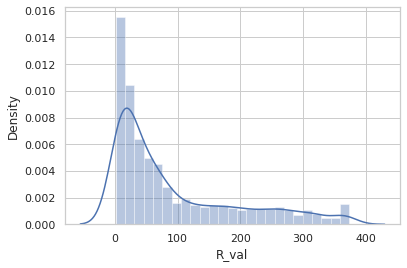

In [146]:
#plot the skewness of recency metric
sns.distplot(grouped['R_val'])

<AxesSubplot:xlabel='F_val', ylabel='Density'>

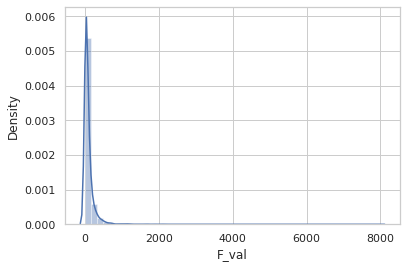

In [147]:
#plot the skewness of frequency metric
sns.distplot(grouped['F_val'])

<AxesSubplot:xlabel='M_val', ylabel='Density'>

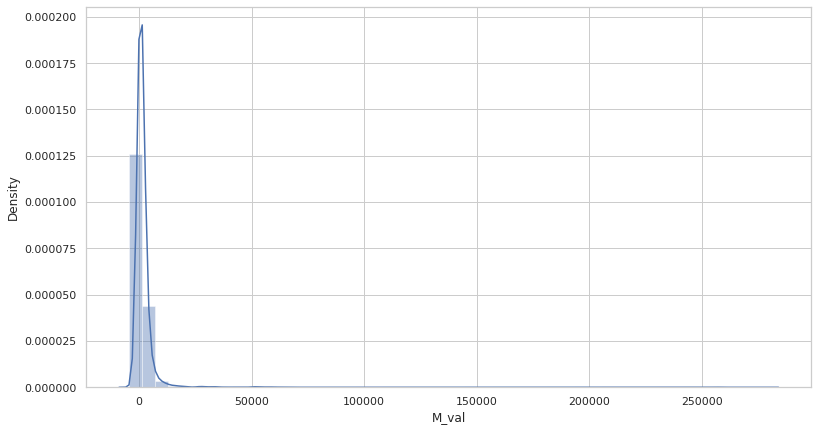

In [148]:
#plot the skewness of monetary metric
fig, ax = plt.subplots(figsize=(13, 7))
sns.distplot(grouped['M_val'])

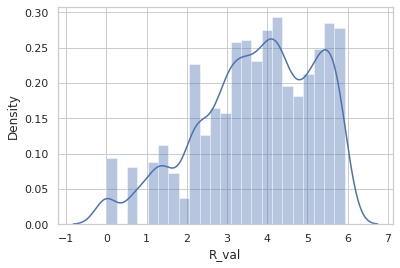

In [149]:
#log transformation of recency metric
recency_log= np.log(grouped['R_val'])

#plot the transformed variable
sns.distplot(recency_log)
plt.show()

In [150]:
#check for variance and mean of the variables
grouped.describe()

,R_val,F_val,M_val,R_quartile,F_quartile,M_quartile,RFM_Score
count,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000
mean,92.047118,93.053294,1898.459701,2.514181,2.487420,2.500000,7.501601
std,100.765435,232.471608,8219.345141,1.124804,1.119114,1.118162,2.828144
min,1.000000,1.000000,-4287.630000,1.000000,1.000000,1.000000,3.000000
25%,17.000000,17.000000,293.362500,2.000000,1.000000,1.750000,5.000000
50%,50.000000,42.000000,648.075000,3.000000,2.000000,2.500000,7.000000
75%,143.000000,102.000000,1611.725000,4.000000,3.000000,3.250000,10.000000
max,374.000000,7983.000000,279489.020000,4.000000,4.000000,4.000000,12.000000


In [151]:
rfm = grouped[['R_val','F_val','M_val']]

#making all values in M_val positive
rfm['M_val']=rfm['M_val']+1

#applying logarithmic transformation
for c in ['R_val', 'F_val']:
    rfm[c]= np.log(rfm[c])
    

#Normalization of variables
from sklearn.preprocessing import StandardScaler

ecomm_standardized= StandardScaler().fit_transform(rfm)
rfm[['R_val','F_val','M_val']]=ecomm_standardized.round(2)

rfm.head()

,R_val,F_val,M_val
CustomerID,,,
12346.0,1.40,-2.23,-0.23
12347.0,-2.08,1.13,0.29
12348.0,0.40,-0.19,-0.01
12349.0,-0.54,0.45,-0.02
12350.0,1.37,-0.63,-0.19


The above step concludes the pre-processig of the data. Now, we use the elbow criterion method to find the optinum number of clusters.

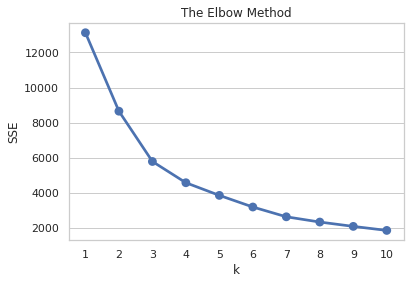

In [152]:
#start k-means clusterig
from sklearn.cluster import KMeans

sse = {}

#find the optimum number of clusters from 1 to 10
for k in range(1, 11):    
    kmeans = KMeans(n_clusters=k, random_state=1)    
    kmeans.fit(rfm)    
    sse[k] = kmeans.inertia_ 
    
# Plot SSE for each value of k    
plt.title('The Elbow Method')
plt.xlabel('k'); 
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [153]:
#fit k-means with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=1)    
kmeans.fit(rfm)

#adding column with cluster labels to a new df
cluster_table = grouped.assign(Cluster=kmeans.labels_)

#group by cluster
clustered_data = cluster_table.groupby(['Cluster'])

#average RFM values for each cluster
clustered_data.agg({
    'R_val': 'mean',
    'F_val': 'mean',
    'M_val': 'mean'
  }).round(2)

,R_val,F_val,M_val
Cluster,,,
0,147.61,28.23,567.25
1,7.67,1828.33,182181.98
2,21.07,170.74,3039.99
